# Scrape data from hotels

In [2]:
%pip install scrapy

  Using cached Scrapy-2.6.1-py2.py3-none-any.whl (264 kB)
  Using cached itemloaders-1.0.4-py3-none-any.whl (11 kB)
  Using cached lxml-4.8.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (6.9 MB)
  Using cached cssselect-1.1.0-py2.py3-none-any.whl (16 kB)
  Using cached Twisted-22.4.0-py3-none-any.whl (3.1 MB)
  Using cached PyDispatcher-2.0.5-py3-none-any.whl
  Using cached service_identity-21.1.0-py2.py3-none-any.whl (12 kB)
  Using cached tldextract-3.2.1-py3-none-any.whl (87 kB)
  Using cached parsel-1.6.0-py2.py3-none-any.whl (13 kB)
  Using cached Protego-0.2.1-py2.py3-none-any.whl (8.2 kB)
  Using cached zope.interface-5.4.0-cp39-cp39-manylinux2010_x86_64.whl (255 kB)
  Using cached itemadapter-0.5.0-py3-none-any.whl (10 kB)
  Using cached w3lib-1.22.0-py2.py3-none-any.whl (20 kB)
  Using cached queuelib-1.6.2-py2.py3-none-any.whl (13 kB)
  Using cached jmespath-1.0.0-py3-none-any.whl (23 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.

In [3]:
import pandas as pd
import scrapy
import requests
import os
import logging
import json
from scrapy.crawler import CrawlerProcess
from IPython.core.display import HTML
import plotly.express as px

In [4]:
cities = ["Mont Saint Michel",
          "St Malo",
          "Bayeux",
          "Le Havre",
          "Rouen",
          "Paris",
          "Amiens",
          "Lille",
          "Strasbourg",
          "Chateau du Haut Koenigsbourg",
          "Colmar",
          "Eguisheim",
          "Besancon",
          "Dijon",
          "Annecy",
          "Grenoble",
          "Lyon",
          "Gorges du Verdon",
          "Bormes les Mimosas",
          "Cassis",
          "Marseille",
          "Aix en Provence",
          "Avignon",
          "Uzes",
          "Nimes",
          "Aigues Mortes",
          "Saintes Maries de la mer",
          "Collioure","Carcassonne",
          "Ariege",
          "Toulouse",
          "Montauban",
          "Biarritz",
          "Bayonne",
          "La Rochelle"]

In [5]:
def to_url(T):
    return [i.replace(" ","+") for i in T]

list_city = to_url(cities)

In [6]:
df_booking = pd.DataFrame(list_city, columns=["city"])
df_booking.head()

,city
0,Mont+Saint+Michel
1,St+Malo
2,Bayeux
3,Le+Havre
4,Rouen


In [7]:
r = requests.get('https://www.booking.com/index.fr.html')
r

<Response [200]>

In [8]:
class BookingSpider(scrapy.Spider):
    name = "Booking_data"
    list_city = df_booking["city"]
    start_urls = ['https://www.booking.com/index.fr.html']

    
    def parse(self, response):
        for x in list_city:
            yield scrapy.FormRequest.from_response(
            response,
            formdata={'ss': x },
            callback=self.after_search
            )
    
    
    def after_search(self, response):
        list_city = response.url.split("ss=")[-1].split("&")[0]
                
        booking = response.css('.d4924c9e74')
        
        for data in booking:
            yield {
                'location': list_city,
                'name': data.css('a div.fcab3ed991.a23c043802::text').getall(),
                'url': data.css('h3.a4225678b2 a::attr(href)').getall(),
                'score': data.css('div.b5cd09854e.d10a6220b4::text').getall(),
                #'rate' : data.css('span.fcab3ed991.bd73d13072::text').getall()
                }
            

In [9]:
filename = "hotel_booking.json"

# If file already exists, delete it before crawling (because Scrapy will 
# concatenate the last and new results otherwise)
if filename in os.listdir('src/'):
        os.remove('src/' + filename)

# to find USER_AGENT: type "my user agent" on Google 
process = CrawlerProcess(settings = {
    'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:92.0) Gecko/20100101 Firefox/92.0',
    'LOG_LEVEL': logging.INFO,
    "FEEDS": {
        'src/' + filename: {"format": "json"},
    }
})

process.crawl(BookingSpider)
process.start()

2022-04-23 14:01:00 [scrapy.utils.log] INFO: Scrapy 2.6.1 started (bot: scrapybot)
2022-04-23 14:01:00 [scrapy.utils.log] INFO: Versions: lxml 4.8.0.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 22.4.0, Python 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) - [GCC 9.4.0], pyOpenSSL 22.0.0 (OpenSSL 1.1.1l  24 Aug 2021), cryptography 36.0.1, Platform Linux-5.4.170+-x86_64-with-glibc2.31
2022-04-23 14:01:00 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 20,
 'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:92.0) '
               'Gecko/20100101 Firefox/92.0'}
2022-04-23 14:01:00 [scrapy.extensions.telnet] INFO: Telnet Password: 38f27cd51acd2910
2022-04-23 14:01:01 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
202

In [10]:
scraping_data = pd.read_json("src/hotel_booking.json")

In [11]:
scraping_data.head()

,location,name,url,score
0,Mont%2BSaint%2BMichel,"[Hôtel Vert, Les Terrasses Poulard, La Mère Po...",[https://www.booking.com/hotel/fr/vert.fr.html...,"[8,1, 7,3, 7,2, 7,8, 8,2, 7,2, 8,0, 7,2, 7,2, ..."
1,Bayeux,"[Le Chat Qui Veille, Domaine de Bayeux, ibis b...",[https://www.booking.com/hotel/fr/gite-6-47-9-...,"[9,9, 9,4, 8,2, 7,9, 8,1, 8,6, 9,8, 8,6, 8,7, ..."
2,St%2BMalo,"[Hôtel Bristol Union Intra Muros, Hotel Eden, ...",[https://www.booking.com/hotel/fr/bristol-unio...,"[8,6, 7,3, 7,9, 8,5, 7,4, 7,5, 8,3, 7,7, 8,0, ..."
3,Amiens,"[Holiday Inn Express Amiens, an IHG Hotel, Com...",[https://www.booking.com/hotel/fr/express-by-h...,"[8,1, 6,9, 8,4, 8,2, 7,9, 9,5, 7,7, 9,3, 7,9, ..."
4,Paris,"[L'Empire Paris, Austin's Saint Lazare Hotel, ...",[https://www.booking.com/hotel/fr/empire-paris...,"[8,2, 8,1, 8,5, 8,3, 8,5, 8,4, 8,0, 8,6, 8,7, ..."


In [12]:
# To reduce the urls
def shorten(T):
    T = T.copy()
    return [i.split("&ucfs=",1)[0] for i in T]

In [13]:
scraping_data["short_url"] = scraping_data["url"].apply(lambda x : shorten(x))
scraping_data["location"] = scraping_data["location"].apply(lambda x : x.replace("%2B"," "))

In [14]:
# Check the results
scraping_data.head()

,location,name,url,score,short_url
0,Mont Saint Michel,"[Hôtel Vert, Les Terrasses Poulard, La Mère Po...",[https://www.booking.com/hotel/fr/vert.fr.html...,"[8,1, 7,3, 7,2, 7,8, 8,2, 7,2, 8,0, 7,2, 7,2, ...",[https://www.booking.com/hotel/fr/vert.fr.html...
1,Bayeux,"[Le Chat Qui Veille, Domaine de Bayeux, ibis b...",[https://www.booking.com/hotel/fr/gite-6-47-9-...,"[9,9, 9,4, 8,2, 7,9, 8,1, 8,6, 9,8, 8,6, 8,7, ...",[https://www.booking.com/hotel/fr/gite-6-47-9-...
2,St Malo,"[Hôtel Bristol Union Intra Muros, Hotel Eden, ...",[https://www.booking.com/hotel/fr/bristol-unio...,"[8,6, 7,3, 7,9, 8,5, 7,4, 7,5, 8,3, 7,7, 8,0, ...",[https://www.booking.com/hotel/fr/bristol-unio...
3,Amiens,"[Holiday Inn Express Amiens, an IHG Hotel, Com...",[https://www.booking.com/hotel/fr/express-by-h...,"[8,1, 6,9, 8,4, 8,2, 7,9, 9,5, 7,7, 9,3, 7,9, ...",[https://www.booking.com/hotel/fr/express-by-h...
4,Paris,"[L'Empire Paris, Austin's Saint Lazare Hotel, ...",[https://www.booking.com/hotel/fr/empire-paris...,"[8,2, 8,1, 8,5, 8,3, 8,5, 8,4, 8,0, 8,6, 8,7, ...",[https://www.booking.com/hotel/fr/empire-paris...


In [15]:
locations = scraping_data.location.to_list()
no_hotels = scraping_data.name.to_list()

In [16]:
def input_loc(loc,N=25):
    L = []
    for i in (loc):
        L += [i] * N
    return L

In [17]:
if (len(input_loc(locations,25)) == len([item for sublist in no_hotels for item in sublist])):
    print("The input is valid :) !")
else:
    print("Problem")

The input is valid :) !


In [18]:
# We initiate the dataframe
right_df = pd.DataFrame()

In [19]:
right_df['name'] = [item for sublist in scraping_data.name.to_list() for item in sublist]
right_df['url'] = [item for sublist in scraping_data.short_url.to_list() for item in sublist]
right_df['location'] = input_loc(locations,25)
#right_df['score'] = [item for sublist in scraping_data.score.to_list() for item in sublist] # Probleme

In [20]:
right_df

,name,url,location
0,Hôtel Vert,https://www.booking.com/hotel/fr/vert.fr.html?...,Mont Saint Michel
1,Les Terrasses Poulard,https://www.booking.com/hotel/fr/les-terrasses...,Mont Saint Michel
2,La Mère Poulard,https://www.booking.com/hotel/fr/la-mere-poula...,Mont Saint Michel
3,Le Relais Saint Michel,https://www.booking.com/hotel/fr/le-relais-sai...,Mont Saint Michel
4,Mercure Mont Saint Michel,https://www.booking.com/hotel/fr/mont-saint-mi...,Mont Saint Michel
...,...,...,...
870,Néméa Appart Hotel Résidence So Cloud,https://www.booking.com/hotel/fr/nemea-appart-...,Lyon
871,ibis Lyon Gerland Musée des Confluences,https://www.booking.com/hotel/fr/ibis-lyon-ger...,Lyon
872,"InterContinental Lyon - Hotel Dieu, an IHG Hotel",https://www.booking.com/hotel/fr/intercontinen...,Lyon
873,Mercure Lyon Centre Saxe Lafayette,https://www.booking.com/hotel/fr/mercure-grand...,Lyon


In [21]:
right_df.to_csv('src/info_hotel.csv')

# Scrape hotel's geographical coordinates

In [1]:
import pandas as pd
import scrapy
import requests
import os
import logging
import json
from scrapy.crawler import CrawlerProcess
from IPython.core.display import HTML
import plotly.express as px
from datetime import datetime

In [2]:
right_df = pd.read_csv("src/info_hotel.csv")

In [3]:
class GeoSpider(scrapy.Spider):
    name = "geodata"
    start_urls = right_df['url'].to_list()
    handle_httpstatus_list = [500]
    
    def parse(self, response):
        geodata = response.css('div.wrap-hotelpage-top')
        return {
            
            'latlon': geodata.css('a::attr(data-atlas-latlng)').get(),
            'address': geodata.css('span.hp_address_subtitle.js-hp_address_subtitle.jq_tooltip::text').get(),
            
            #'desc':geodata.css('div.property_description_content > p ::text').getall(),
        
            # Return start url to be able to join the data with left_df
            'url': response.url,
        }

In [4]:
filename = "hotel_geodata.json"

if filename in os.listdir('src/'):
        os.remove('src/' + filename)

process_geo = CrawlerProcess(settings = {
    'USER_AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
    'LOG_LEVEL': logging.INFO,
    "FEEDS": {
        'src/' + filename : {"format": "json"},
    }
})
process_geo.crawl(GeoSpider)
process_geo.start()

2022-04-23 14:04:31 [scrapy.utils.log] INFO: Scrapy 2.6.1 started (bot: scrapybot)
2022-04-23 14:04:31 [scrapy.utils.log] INFO: Versions: lxml 4.8.0.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 22.4.0, Python 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) - [GCC 9.4.0], pyOpenSSL 22.0.0 (OpenSSL 1.1.1l  24 Aug 2021), cryptography 36.0.1, Platform Linux-5.4.170+-x86_64-with-glibc2.31
2022-04-23 14:04:31 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 20,
 'USER_AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) '
               'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 '
               'Safari/537.36'}
2022-04-23 14:04:31 [scrapy.extensions.telnet] INFO: Telnet Password: 4d962f2f4fc1dc6c
2022-04-23 14:04:31 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexpo

In [5]:
left_df = pd.read_json("src/hotel_geodata.json")
left_df.head()

,latlon,address,url
0,"48.63534943,-1.51037872","\nGrande Rue, 50170 Le Mont-Saint-Michel, Fran...",https://www.booking.com/hotel/fr/les-terrasses...
1,"48.61424653,-1.51054502","\nLa Caserne, 50170 Le Mont-Saint-Michel, Fran...",https://www.booking.com/hotel/fr/mont-saint-mi...
2,"48.61758727,-1.51039615","\nLa Caserne, 50170 Le Mont-Saint-Michel, Fran...",https://www.booking.com/hotel/fr/le-relais-sai...
3,"48.61688155,-1.51091784","\nLa Caserne, 50170 Le Mont-Saint-Michel, Fran...",https://www.booking.com/hotel/fr/de-la-digue.f...
4,"48.61538141,-1.51070997","\nRoute du Mont Saint Michel, 50170 Le Mont-Sa...",https://www.booking.com/hotel/fr/hotel-gabriel...


In [6]:
# Process the latitude & longitude
left_df['lat'] = left_df['latlon'].apply(lambda x : x.split(',')[0])
left_df['lon'] = left_df['latlon'].apply(lambda x : x.split(',')[1])

# Correct the address
left_df['address'] = left_df['address'].apply(lambda x : x.replace('\n',''))

In [7]:
left_df.head()

,latlon,address,url,lat,lon
0,"48.63534943,-1.51037872","Grande Rue, 50170 Le Mont-Saint-Michel, France",https://www.booking.com/hotel/fr/les-terrasses...,48.63534943,-1.51037872
1,"48.61424653,-1.51054502","La Caserne, 50170 Le Mont-Saint-Michel, France",https://www.booking.com/hotel/fr/mont-saint-mi...,48.61424653,-1.51054502
2,"48.61758727,-1.51039615","La Caserne, 50170 Le Mont-Saint-Michel, France",https://www.booking.com/hotel/fr/le-relais-sai...,48.61758727,-1.51039615
3,"48.61688155,-1.51091784","La Caserne, 50170 Le Mont-Saint-Michel, France",https://www.booking.com/hotel/fr/de-la-digue.f...,48.61688155,-1.51091784
4,"48.61538141,-1.51070997","Route du Mont Saint Michel, 50170 Le Mont-Sain...",https://www.booking.com/hotel/fr/hotel-gabriel...,48.61538141,-1.51070997


In [8]:
right_df.drop(columns=['Unnamed: 0'],inplace=True)
left_df.drop(columns=['latlon'],inplace=True)

In [9]:
right_df.head()

,name,url,location
0,Hôtel Vert,https://www.booking.com/hotel/fr/vert.fr.html?...,Mont Saint Michel
1,Les Terrasses Poulard,https://www.booking.com/hotel/fr/les-terrasses...,Mont Saint Michel
2,La Mère Poulard,https://www.booking.com/hotel/fr/la-mere-poula...,Mont Saint Michel
3,Le Relais Saint Michel,https://www.booking.com/hotel/fr/le-relais-sai...,Mont Saint Michel
4,Mercure Mont Saint Michel,https://www.booking.com/hotel/fr/mont-saint-mi...,Mont Saint Michel


In [10]:
df_hotel = pd.merge(
    right_df,
    left_df,
    how='inner',
    on='url',
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None)

In [11]:
df_hotel

,name,url,location,address,lat,lon
0,Maison Nô - Hôtel et Rooftop,https://www.booking.com/hotel/fr/11-bda.fr.htm...,Lyon,"11 Rue du Bat d'Argent, 1er arr., 69001 Lyon, ...",45.76624700,4.83550400
1,Studio avec Jardin et Parking Privés,https://www.booking.com/hotel/fr/217-rue-des-i...,Bormes les Mimosas,"217 Rue des Iris, 83230 Bormes-les-Mimosas, Fr...",43.14036330,6.33671490
2,33 Bis,https://www.booking.com/hotel/fr/33-bis.fr.htm...,La Rochelle,"33 bis chemin des chirons longs, 17000 La Roch...",46.16458800,-1.20497900
3,6AMB38-Villa avec terrasse VUE DANS RESIDENCE ...,https://www.booking.com/hotel/fr/6amb38-villa-...,Collioure,"Résidence d'Ambeille, 66190 Collioure, France",42.52470400,3.07853500
4,A l'ombre du Palais,https://www.booking.com/hotel/fr/a-l-39-ombre-...,Avignon,"25 RUE BERTRAND, 84000 Avignon, France",43.95172900,4.81033900
...,...,...,...,...,...,...
870,Votre adresse de charme hypercentre,https://www.booking.com/hotel/fr/votre-adresse...,Marseille,"4 Rue DELILLE, 13001 Marseille, France",43.30020105,5.38260245
871,Le Domaine de Françon,https://www.booking.com/hotel/fr/vtf-le-domain...,Biarritz,"81 rue de Salon, 64200 Biarritz, France",43.46218084,-1.55973185
872,Welk'Home Loft Rouen CHU - Coeur Historique,https://www.booking.com/hotel/fr/welk-39-home-...,Rouen,"Rez-de-Jardin 10 Rue Eau de Robec, 76000 Rouen...",49.44164990,1.11061080
873,Westside Arc de Triomphe Hotel,https://www.booking.com/hotel/fr/westside-arc-...,Paris,"36 rue Pierre Demours, 17e arr., 75017 Paris, ...",48.88129894,2.29480304


In [12]:
date = datetime.today().strftime('%Y-%m-%d')

In [13]:
hotels = df_hotel[['name','url','location','address','lat','lon']]
hotels.to_csv('src/{}_complete_info_hotel.csv'.format(date))

## Plot the hotels on the map

In [14]:
df_hotel["latitude"] = pd.to_numeric(df_hotel["lat"])
df_hotel["longitude"] = pd.to_numeric(df_hotel["lon"])

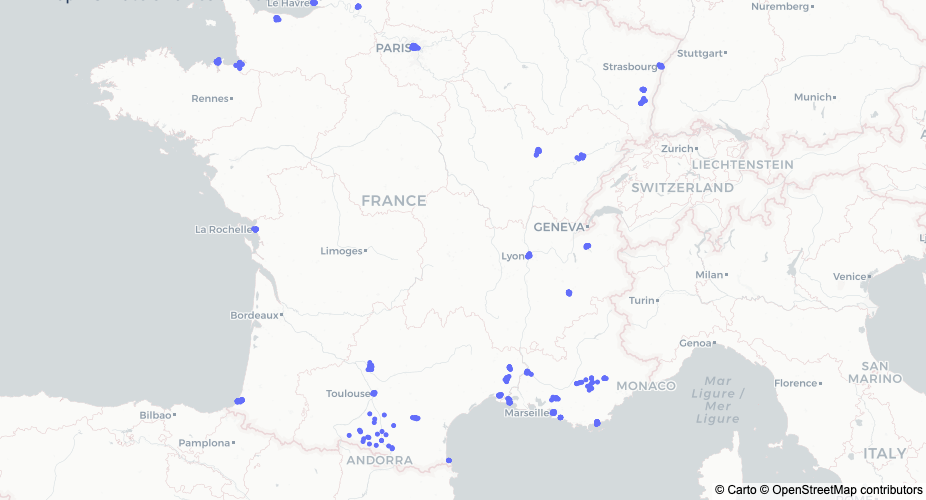

In [18]:
fig = px.scatter_mapbox(df_hotel, 
                        lat="latitude", 
                        lon="longitude",
                        mapbox_style="carto-positron",
                        hover_name="name",
                        zoom=5,
                        height=500,
                        title="Top 25 hotels for each destination")


fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()